In [2]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from time import perf_counter
import warnings
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv(r"dataset\spam_ham_dataset.csv")

In [4]:
# Loại bỏ các dữ liệu trống
df.drop('Unnamed: 0', axis=1, inplace=True)
df.columns = ['lable', 'text', 'lable_num']

print("Bộ Dữ Liệu")
df.head()

Bộ Dữ Liệu


,lable,text,lable_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
print("Kích Thước Bộ Dữ Liệu")
df.shape

Kích Thước Bộ Dữ Liệu


(5171, 3)

In [6]:
print("Kiểm Tra Lại Bộ Dữ Liệu")
df.info()

Kiểm Tra Lại Bộ Dữ Liệu
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lable      5171 non-null   object
 1   text       5171 non-null   object
 2   lable_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [7]:
t = df['lable_num'].value_counts()
print(t)

0    3672
1    1499
Name: lable_num, dtype: int64


In [8]:
# Tiền Xử Lý Dữ Liệu
def clean_data(string, reg=RegexpTokenizer(r'[a-zA-Z0-9]+')):
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)


print("Tiền Xử Lý Dữ Liệu")
df['text'] = df['text'].apply(lambda string: clean_data(string))
df.head()

Tiền Xử Lý Dữ Liệu


,lable,text,lable_num
0,ham,subject enron methanol meter 988291 this is a ...,0
1,ham,subject hpl nom for january 9 2001 see attache...,0
2,ham,subject neon retreat ho ho ho we re around to ...,0
3,spam,subject photoshop windows office cheap main tr...,1
4,ham,subject re indian springs this deal is to book...,0


In [9]:
print("Thêm Cột Đếm Số Từ Trong Mail Vào Bộ Dữ Liệu")
def count_words(txt):
    words = word_tokenize(txt)
    return len(words)


df['count'] = df['text'].apply(count_words)
df.head()

Thêm Cột Đếm Số Từ Trong Mail Vào Bộ Dữ Liệu


,lable,text,lable_num,count
0,ham,subject enron methanol meter 988291 this is a ...,0,53
1,ham,subject hpl nom for january 9 2001 see attache...,0,16
2,ham,subject neon retreat ho ho ho we re around to ...,0,469
3,spam,subject photoshop windows office cheap main tr...,1,44
4,ham,subject re indian springs this deal is to book...,0,64


In [10]:
df.groupby('lable_num').mean()

,count
lable_num,
0,156.044390
1,186.176785


In [11]:
# Stemming Words -
stemmer = PorterStemmer()


def stemming(txt):
    return ''.join([stemmer.stem(word) for word in txt])


df['text'] = df['text'].apply(stemming)
df.head()

,lable,text,lable_num,count
0,ham,subject enron methanol meter 988291 this is a ...,0,53
1,ham,subject hpl nom for january 9 2001 see attache...,0,16
2,ham,subject neon retreat ho ho ho we re around to ...,0,469
3,spam,subject photoshop windows office cheap main tr...,1,44
4,ham,subject re indian springs this deal is to book...,0,64


In [12]:
x = df.loc[:, 'text']
y = df.loc[:, 'lable_num']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=200)
print(f"Size Training Data: {x_train.shape} \n")
print(f"Size Test Data: {x_test.shape} \n")

Size Training Data: (3619,) 

Size Test Data: (1552,) 



In [13]:
# dùng CountVectorizer trích rút Features từ Text
cv = CountVectorizer()
cv.fit(x_train)
print("Số lượng từ vựng(Features): ", len(cv.vocabulary_.keys()))

Số lượng từ vựng(Features):  41573


In [14]:
dtv = cv.transform(x_train)
type(dtv)
pickle.dump(cv, open("Vector.pkl", "wb"))

dtv = dtv.toarray()
print(dtv)
print(f"Input Training Data: {dtv.shape[0]} \n")

[[0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Input Training Data: 3619 



In [16]:
warnings.filterwarnings(action='ignore')
models = {
    "Ramdom Forest": {"model": RandomForestClassifier(), "perf": 0},
    "MultinomialNB": {"model": MultinomialNB(), "perf": 0},
    "Logistic Regression": {"model": LogisticRegression(solver='liblinear', penalty='l2', C=1.0), "perf": 0},
    "KNeighbors": {"model": KNeighborsClassifier(), "perf": 0},
    "Decision Tree": {"model": DecisionTreeClassifier(), "perf": 0},
    "LinearSVC": {"model": LinearSVC(), "perf": 0}
}

for name, model in models.items():
    start = perf_counter()
    model["model"].fit(dtv, y_train)
    duration = perf_counter() - start  # tính giờ train
    duration = round(duration, 3)
    model["perf"] = duration
    print(f"{name:30} trained in {duration} sec")

Ramdom Forest                  trained in 20.356 sec
MultinomialNB                  trained in 3.016 sec
Logistic Regression            trained in 2.885 sec
KNeighbors                     trained in 0.001 sec
Decision Tree                  trained in 18.959 sec
LinearSVC                      trained in 1.192 sec


In [17]:
test_dtv = cv.transform(x_test)
test_dtv = test_dtv.toarray()
print(f"Input Test Data: {test_dtv.shape[0]} \n")

# Test Accuracy and Training Time
modles_accuracy = []
for name1, model1 in models.items():
    modles_accuracy.append([name1, model1["model"].score(test_dtv, y_test), model1["perf"]])

df_accuracy = pd.DataFrame(modles_accuracy)
df_accuracy.columns = ['Model', 'Test Accuracy', 'Training Time (sec)']
df_accuracy.sort_values(by='Test Accuracy', ascending=False, inplace=True)
df_accuracy.reset_index(drop=True, inplace=True)
print(df_accuracy)

Input Test Data: 1552 

                 Model  Test Accuracy  Training Time (sec)
0        MultinomialNB       0.974227                3.016
1  Logistic Regression       0.972294                2.885
2        Ramdom Forest       0.967784               20.356
3            LinearSVC       0.963918                1.192
4        Decision Tree       0.949742               18.959
5           KNeighbors       0.839562                0.001


Logistic Regression Accuracy:  97.22938144329896
Logistic Regression 

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1101
           1       0.94      0.96      0.95       451

    accuracy                           0.97      1552
   macro avg       0.96      0.97      0.97      1552
weighted avg       0.97      0.97      0.97      1552



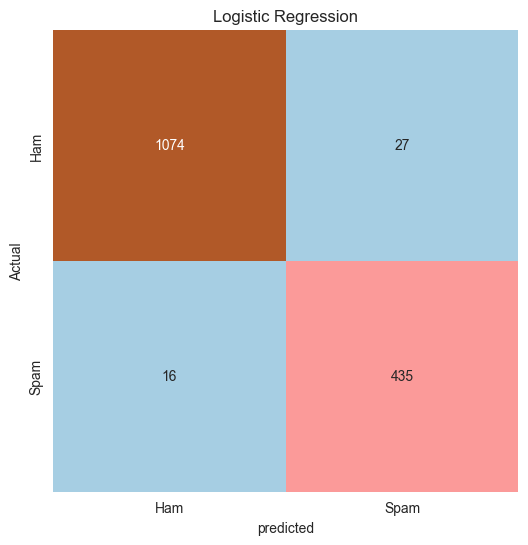

In [18]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear', penalty='l2', C=1.0)
lr.fit(dtv, y_train)
predict_1 = lr.predict(test_dtv)
pickle.dump(lr, open("logistic.pkl", "wb"))
print("Logistic Regression Accuracy: ", accuracy_score(y_test, predict_1) * 100)

# Classìfication Report
print("Logistic Regression \n")
print(classification_report(y_test, predict_1))

confusion_matrix = pd.crosstab(y_test, predict_1, rownames=['Actual'], colnames=['predicted'])
plt.figure(figsize=(6, 6))
plt.title('Logistic Regression')
sns.heatmap(confusion_matrix, annot=True, cmap='Paired', cbar=False, fmt="d", xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.show()

Decision Tree Accuracy:  94.39432989690721
Decision Tree Classifier 

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1101
           1       0.89      0.92      0.91       451

    accuracy                           0.94      1552
   macro avg       0.93      0.94      0.93      1552
weighted avg       0.94      0.94      0.94      1552



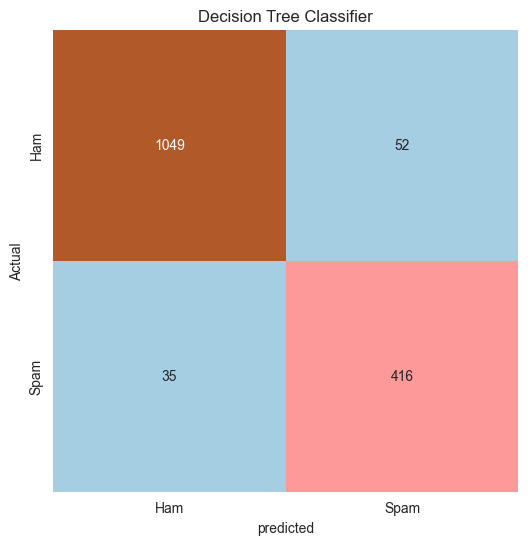

In [19]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(dtv, y_train)
predict_2 = dt.predict(test_dtv)
pickle.dump(dt, open("DecisionTree.pkl", "wb"))
print("Decision Tree Accuracy: ", accuracy_score(y_test, predict_2) * 100)

# Classìfication Report
print("Decision Tree Classifier \n")
print(classification_report(y_test, predict_2))

confusion_matrix = pd.crosstab(y_test, predict_2, rownames=['Actual'], colnames=['predicted'])
plt.figure(figsize=(6, 6))
plt.title('Decision Tree Classifier')
sns.heatmap(confusion_matrix, annot=True, cmap='Paired', cbar=False, fmt="d", xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.show()

Random Forest Accuracy:  96.90721649484536
Random Forest Classifier 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1101
           1       0.94      0.95      0.95       451

    accuracy                           0.97      1552
   macro avg       0.96      0.96      0.96      1552
weighted avg       0.97      0.97      0.97      1552



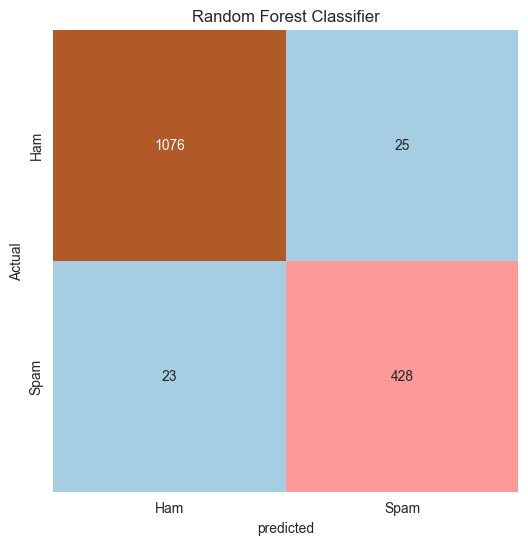

In [20]:
# Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(dtv, y_train)
predict_3 = rfc.predict(test_dtv)
pickle.dump(rfc, open("RandomForest.pkl", "wb"))
print("Random Forest Accuracy: ", accuracy_score(y_test, predict_3) * 100)

# Classìfication Report
print("Random Forest Classifier \n")
print(classification_report(y_test, predict_3))

confusion_matrix = pd.crosstab(y_test, predict_3, rownames=['Actual'], colnames=['predicted'])
plt.figure(figsize=(6, 6))
plt.title('Random Forest Classifier')
sns.heatmap(confusion_matrix, annot=True, cmap='Paired', cbar=False, fmt="d", xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.show()

Multinomial Naive Bayes Accuracy:  97.42268041237114
Multinomial Naive Bayes 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1101
           1       0.97      0.94      0.96       451

    accuracy                           0.97      1552
   macro avg       0.97      0.97      0.97      1552
weighted avg       0.97      0.97      0.97      1552



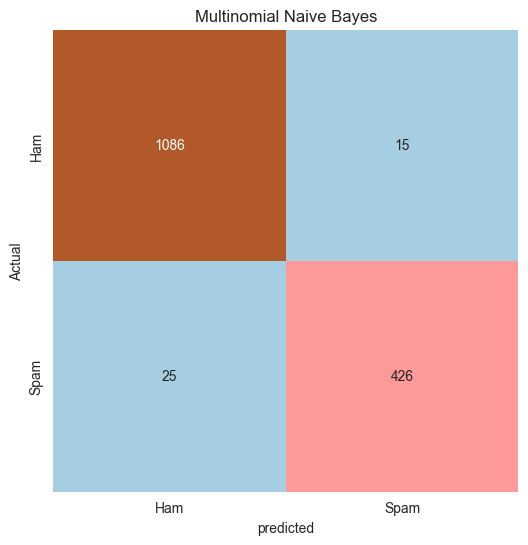

In [21]:
# Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(dtv, y_train)
predict_4 = mnb.predict(test_dtv)
pickle.dump(mnb, open("MultinomialNB.pkl", "wb"))
print("Multinomial Naive Bayes Accuracy: ", accuracy_score(y_test, predict_4) * 100)

# Classìfication Report
print("Multinomial Naive Bayes \n")
print(classification_report(y_test, predict_4))

confusion_matrix = pd.crosstab(y_test, predict_4, rownames=['Actual'], colnames=['predicted'])
plt.figure(figsize=(6, 6))
plt.title('Multinomial Naive Bayes')
sns.heatmap(confusion_matrix, annot=True, cmap='Paired', cbar=False, fmt="d", xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.show()

LinearSVC Accuracy:  96.3917525773196
LinearSVC 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1101
           1       0.93      0.94      0.94       451

    accuracy                           0.96      1552
   macro avg       0.95      0.96      0.96      1552
weighted avg       0.96      0.96      0.96      1552



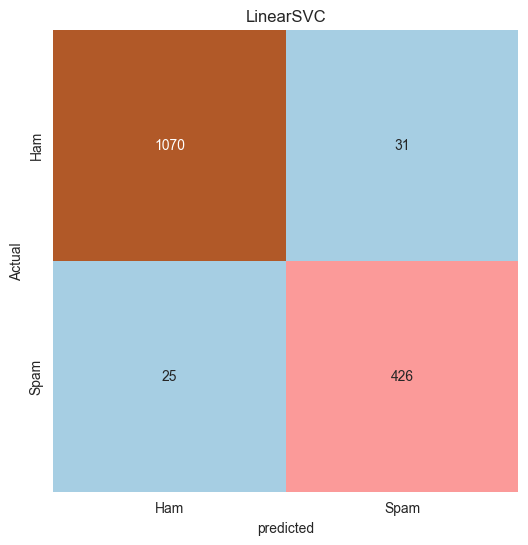

In [22]:
# Linear SVC
lsvc = LinearSVC()
lsvc.fit(dtv, y_train)
predict_5 = lsvc.predict(test_dtv)
pickle.dump(lsvc, open("LinearSVC.pkl", "wb"))
print("LinearSVC Accuracy: ", accuracy_score(y_test, predict_5) * 100)

# Classìfication Report
print("LinearSVC \n")
print(classification_report(y_test, predict_5))

confusion_matrix = pd.crosstab(y_test, predict_5, rownames=['Actual'], colnames=['predicted'])
plt.figure(figsize=(6, 6))
plt.title('LinearSVC')
sns.heatmap(confusion_matrix, annot=True, cmap='Paired', cbar=False, fmt="d", xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.show()

K Neighbors Classifie Accuracy:  83.95618556701031
K Neighbors Classifie 

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1101
           1       0.67      0.86      0.76       451

    accuracy                           0.84      1552
   macro avg       0.81      0.85      0.82      1552
weighted avg       0.86      0.84      0.84      1552



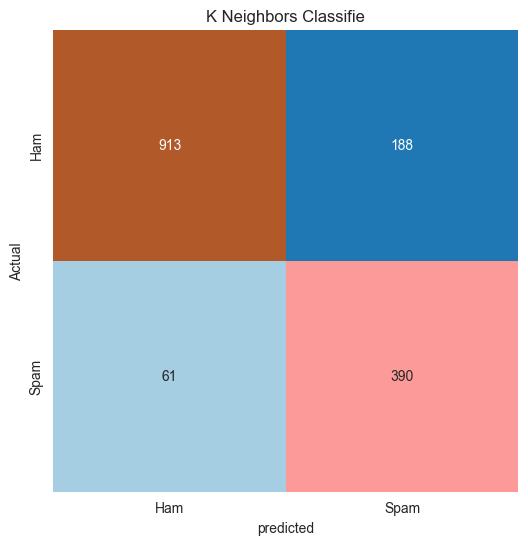

In [23]:
# K Neighbors Classifie
knn = KNeighborsClassifier()
knn.fit(dtv, y_train)
predict_6 = knn.predict(test_dtv)
pickle.dump(knn, open("KNeighbors.pkl", "wb"))
print("K Neighbors Classifie Accuracy: ", accuracy_score(y_test, predict_6) * 100)

# Classìfication Report
print("K Neighbors Classifie \n")
print(classification_report(y_test, predict_6))

confusion_matrix = pd.crosstab(y_test, predict_6, rownames=['Actual'], colnames=['predicted'])
plt.figure(figsize=(6, 6))
plt.title('K Neighbors Classifie')
sns.heatmap(confusion_matrix, annot=True, cmap='Paired', cbar=False, fmt="d", xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.show()